In [1]:
import numpy as np
def thomas_algorithm(out, a, b, d, cprime, dprime, X):
    cprime[0] = a / b
    dprime[0]
    for i in range(1, X):
        cprime[i] = a / (b - a * cprime[i - 1])
        dprime[i] = (d[i] - a * dprime[i - 1]) / (b - a * cprime[i - 1])

    out[X - 1] = dprime[X - 1]
    for i in range(X - 2, -1, -1):
        out[i] = dprime[i] - cprime[i] * out[i + 1]


In [2]:
X = 10
a = 1
b = -4
out = [0 for _ in range(X)]
d = [i for i in range(X)]
cprime = [0 for _ in range(X)]
dprime = [0 for _ in range(X)]

In [3]:
thomas_algorithm(out, a, b, d, cprime, dprime, X)

In [4]:
out

[-0.13396574225411223,
 -0.5358629690164489,
 -1.0094861338116834,
 -1.5020815662302844,
 -1.9988401311094544,
 -2.4932789582075334,
 -2.974275701720679,
 -3.4038238486751817,
 -3.6410196929800485,
 -3.160254923245012]

In [5]:
import scipy
A = np.zeros((3, X))
A[0, 1:] = a
A[1, :] = b
A[2, :-1] = a
sc_out = scipy.linalg.solve_banded((1, 1), A, d)

In [6]:
sc_out

array([-0.13396574, -0.53586297, -1.00948613, -1.50208157, -1.99884013,
       -2.49327896, -2.9742757 , -3.40382385, -3.64101969, -3.16025492])

In [58]:

INT = np.s_[1:-1, 1:-1]
XINT = np.s_[2:, 1:-1]
XMINT = np.s_[:-2, 1:-1]
YINT = np.s_[1:-1, 2:]
YMINT = np.s_[1:-1, :-2]

def bcu(u, K):
    # (sorry for no notation help)
    # Ut = 2Uw-Ub
    # top - sliding wall
    u[1:-1, 0, 0] = 2 * K - u[1:-1, 1, 0]
    #u[1:-1, 0, 0] = - u[1:-1, 1, 0]
    u[1:-1, 0, 1] = - u[1:-1, 1, 1]
    # bot - no slip
    u[1:-1, -1, :] = - u[1:-1, -2, :]
    # left - no slip
    u[0, 1:-1, :] = - u[1, 1:-1, :]
    # right - no slip
    u[-1, 1:-1, :] = - u[-2, 1:-1, :]
    # corners
    u[ 0,  0, :] = (u[ 1,  0, :] + u[ 0,  1, :]) / 2
    u[-1,  0, :] = (u[-2,  0, :] + u[-1,  1, :]) / 2
    u[ 0, -1, :] = (u[ 1, -1, :] + u[ 0, -2, :]) / 2
    u[-1, -1, :] = (u[-1, -2, :] + u[-2, -1, :]) / 2

def ei_adi(out, u, inter_u, xbuf1, xbuf2, X, K, dx, nu, dt):
    a = 1 * nu * dt / (dx * dx)
    b = -2 * nu * dt / (dx * dx)

    bcu(u, K)
    for j in range(1, X - 1):
        thomas_algorithm(inter_u[:, j, 0], -a, 1 + b, u[:, j, 0], xbuf1, xbuf2, X)
        thomas_algorithm(inter_u[:, j, 1], -a, 1 + b, u[:, j, 1], xbuf1, xbuf2, X)
    

    bcu(inter_u, K)
    for i in range(1, X - 1):
        thomas_algorithm(out[i, :, 0], -a, 1 + b, inter_u[i, :, 0], xbuf1, xbuf2, X)
        thomas_algorithm(out[i, :, 1], -a, 1 + b, inter_u[i, :, 1], xbuf1, xbuf2, X)
    

In [88]:
def cn_adi(out, u, inter_u, xbuf1, xbuf2, X, K, dx, nu, dt):
    theta = 0.5
    a = theta *  1 * nu * dt / (dx * dx)
    b = theta * -2 * nu * dt / (dx * dx)

    bcu(u, K)
    
    der2 = u.copy()
    der2[INT][..., 0] = u[INT][..., 0] + (u[YINT][..., 0] + u[YMINT][..., 0] - 2 * u[INT][..., 0]) * nu * dt * 1 / (dx * dx)
    der2[INT][..., 1] = u[INT][..., 1] + (u[YINT][..., 1] + u[YMINT][..., 1] - 2 * u[INT][..., 1]) * nu * dt * 1 / (dx * dx)
    bcu(der2, K)
    for j in range(1, X - 1):
        thomas_algorithm(inter_u[:, j, 0], -a, 1 + b, der2[:, j, 0], xbuf1, xbuf2, X)
        thomas_algorithm(inter_u[:, j, 1], -a, 1 + b, der2[:, j, 1], xbuf1, xbuf2, X)

    
    bcu(inter_u, K)
    der2[INT][..., 0] = inter_u[INT][..., 0] + (inter_u[XINT][..., 0] + inter_u[XMINT][..., 0] - 2 * inter_u[INT][..., 0]) * nu * dt * 1 / (dx * dx)
    der2[INT][..., 1] = inter_u[INT][..., 1] + (inter_u[XINT][..., 1] + inter_u[XMINT][..., 1] - 2 * inter_u[INT][..., 1]) * nu * dt * 1 / (dx * dx)
    bcu(der2, K)
    
    for i in range(1, X - 1):
        thomas_algorithm(out[i, :, 0], -a, 1 + b, der2[i, :, 0], xbuf1, xbuf2, X)
        thomas_algorithm(out[i, :, 1], -a, 1 + b, der2[i, :, 1], xbuf1, xbuf2, X)

In [101]:
# (I - νΔt ∇2) un+1 = un

nu = 1 / 100
dt = 1e-3
dx = 1.0 / X

V = np.diagflat(np.ones(X) * -4 * nu * dt / (dx * dx), 0) + np.diagflat(np.ones(X - 1) * 1 * nu * dt / (dx * dx), 1) + np.diagflat(np.ones(X - 1) * 1 * nu * dt / (dx * dx), -1)
un = np.random.rand(X, X, 2)
bcu(un, 1.0)
I = np.eye(X, X)


In [102]:
out = np.zeros((X, X, 2))
inter_u = np.zeros((X, X, 2))
cn_adi(out, un, inter_u, cprime, dprime, X, 1.0, dx, nu, dt)
bcu(out, 1.0)

In [103]:
A = I - nu * dt * V
B = un

In [104]:
solve_X = np.linalg.solve(A, B)
bcu(solve_X, 1.0)

In [105]:
err_pct = 100 * np.linalg.norm(out - solve_X) / np.linalg.norm(solve_X)
err_pct

np.float64(0.33453275439942953)

In [106]:
out = np.zeros((X, X, 2))
inter_u = np.zeros((X, X, 2))
ei_adi(out, un, inter_u, cprime, dprime, X, 1.0, dx, nu, dt)
bcu(out, 1.0)
err_pct = 100 * np.linalg.norm(out - solve_X) / np.linalg.norm(solve_X)
err_pct

np.float64(0.3819473752893884)

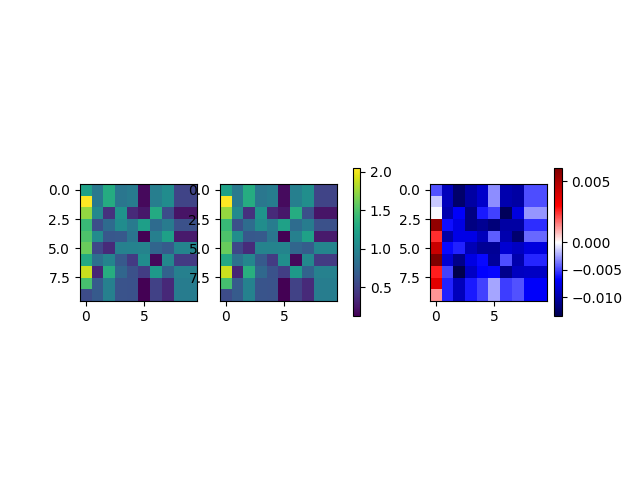

In [45]:
%matplotlib widget


from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import numpy as np

nsolve_X = np.linalg.norm(solve_X, axis=-1)
nout = np.linalg.norm(out, axis=-1)

# same scale for first two
vmin = min(nsolve_X.min(), nout.min())
vmax = max(nsolve_X.max(), nout.max())
norm_main = Normalize(vmin=vmin, vmax=vmax)

# centered scale for difference
diff = nsolve_X - nout
norm_diff = TwoSlopeNorm(vmin=diff.min(), vcenter=0.0, vmax=diff.max())

fig, axs = plt.subplots(1, 3)

axs[0].imshow(nsolve_X, norm=norm_main, cmap="viridis")
axs[1].imshow(nout,     norm=norm_main, cmap="viridis")
im2 = axs[2].imshow(diff, norm=norm_diff, cmap="seismic")

fig.colorbar(axs[1].images[0], ax=axs[:2], shrink=0.4)
fig.colorbar(im2, ax=axs[2], shrink=0.4)
plt.show()

np.float64(0.9152092570920124)

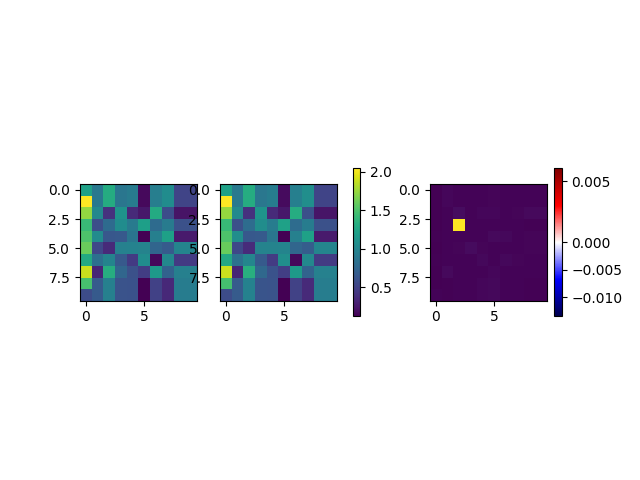

In [47]:
err_map = 100 * np.abs(out - solve_X) / (np.abs(solve_X) + 1e-12)
plt.imshow(err_map[..., 0])
plt.show()


In [48]:
err_pct = 100 * np.max(np.abs(out - solve_X)) / np.max(np.abs(solve_X))
err_pct

np.float64(0.5460507313478483)

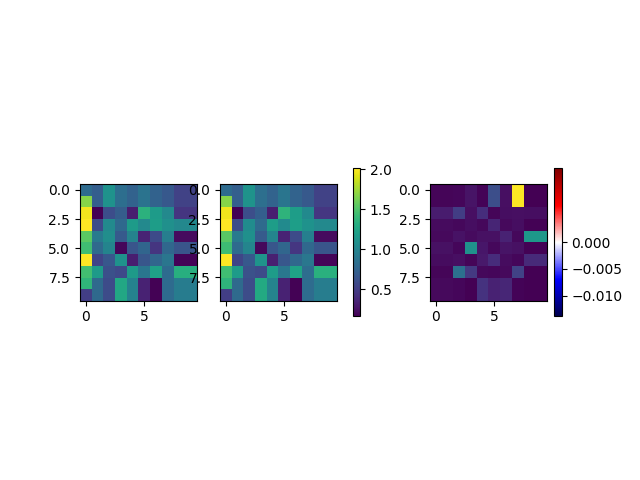

In [39]:
plt.imshow(err_map[..., 1])
plt.show()